# 0.1.4: Build GBIF trait maps

The final step before training models using Earth observation (EO) data is to link the TRY trait data with the GBIF species observations and then grid them. In this way, we can have matching trait rasters to be paired with our EO data.

## Imports and config

In [1]:
from pathlib import Path

import dask.dataframe as dd
import numpy as np
import pandas as pd
import rioxarray as riox
from src.conf.conf import get_config
from src.conf.environment import log
from src.utils.raster_utils import create_sample_raster

%load_ext autoreload
%autoreload 2

# Display all columns when printing a pandas DataFrame
pd.set_option("display.max_columns", None)

cfg = get_config()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Due to the size of the GBIF data, we're going to need to use Dask in order to keep memory usage low as well as to parallelize the merging and spatial gridding operations. The settings below (`n_workers` and `memory_limit`, in particular) are specific to the machine being used during this exercise.

In [2]:
from src.utils.dask_utils import init_dask

client, cluster = init_dask(
    dashboard_address=cfg.dask_dashboard,
    n_workers=40,
    threads_per_worker=5,
)

## Load GBIF and filter by PFT

Let's load the GBIF data, select all three PFTs, and set species name as the index to make merging with the TRY data faster.

**Note:** Processing the entire GBIF dataset, as done below, may be infeasible for some machines. If this is the case, simply select a single PFT for the `filter_pft` call, and also consider using `DataFrame.sample(frac=<fraction of the data>)` to use only a subsample of the data.

In [3]:
from src.utils.trait_utils import filter_pft

gbif = (
    dd.read_parquet(
        Path(cfg.interim_dir, cfg.gbif.interim.dir, cfg.gbif.interim.subsampled)
    )
    .pipe(filter_pft, "Shrub_Tree_Grass")
    .set_index("speciesname")
)

## Load TRY filtered mean trait data

In [4]:
mn_traits = dd.read_parquet(
    Path(cfg.interim_dir, cfg.trydb.interim.dir, cfg.trydb.interim.filtered)
).set_index("speciesname")

## Link mean trait values with GBIF data

Because we set species name as the index on both DataFrames, we can simply perform an inner join, called by the GBIF data, to merge the traits and cit-sci species occurrences.

In [5]:
merged = gbif.join(mn_traits, how="inner")

In [6]:
# compute the number of unique indices
print(
    f"Pct matched species: {merged.index.nunique().compute() / gbif.index.nunique().compute():.2%}"
)

## Rasterize merged trait values

### Grid the matched trait data

Now let's grid the data for the first trait, "X4" or "stem specific density". 

`global_grid_df` grids the data to the centroids of each point observations corresponding grid cell (at the desired resolution), and then calculates the mean, standard deviation, median, and 5th and 95th quantiles of each grid cell.

First reproject the merged data to NSIDC Equal-Area Scalable Earth 2.0 (EPSG: 6933) coordinates.

In [8]:
from src.utils.df_utils import reproject_geo_to_xy


merged_6933 = (
    merged.reset_index(drop=True)
    .map_partitions(
        reproject_geo_to_xy,
        x_col="decimallongitude",
        y_col="decimallatitude",
    )
    .drop(columns=["decimallongitude", "decimallatitude", "pft"])
)

In [9]:
from src.utils.df_utils import agg_df, xy_to_rowcol_df

transform = create_sample_raster(resolution=1000, crs="EPSG:6933").rio.transform()

# Convert the Affine object to a tuple for serialization across Dask workers
transform_tuple = transform.to_gdal()

cols = [col for col in merged_6933.columns if col.startswith("X")]
df = xy_to_rowcol_df(merged_6933[["x", "y", cols[0]]], transform_tuple).drop(
    columns=["x", "y"]
)

df = agg_df(df, ["row", "col"], "X4")

In [25]:
agg = df.compute()

In [26]:
agg.head()

,,mean,std,median,q05,q95,count
row,col,,,,,,
6536,10064,0.535843,0.085337,0.578245,0.386043,0.662060,84
7131,9959,0.517509,NaN,0.517509,0.517509,0.517509,1
7298,9785,0.498631,0.088076,0.502703,0.407313,0.632198,89
7338,9805,0.467158,0.043992,0.460785,0.431581,0.517509,12
6750,10219,0.516574,0.151766,0.470725,0.344335,0.792989,52


In [29]:
agg5 = agg[agg["count"] >= 5]
agg10 = agg[agg["count"] >= 10]
agg20 = agg[agg["count"] >= 20]
agg50 = agg[agg["count"] >= 50]

In [32]:
from src.utils.df_utils import rasterize_points


rast = rasterize_points(
    merged_6933[["x", "y", cols[0]]], data=cols[0], res=1000, crs="EPSG:6933"
)

In [54]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# fig, axes = plt.subplots(
#     5, 1, subplot_kw=dict(projection=ccrs.EqualEarth()), figsize=(22 * 5, 10 * 5)
# )

# axes = axes.ravel()

min_counts = [1, 5, 10, 20, 50]

for min_count in min_counts:
    r = rast["count"].where(rast["count"] >= min_count)
    print(r.notnull().sum().values)
    # r.coarsen(
    #     x=10, y=10, boundary="trim"
    # ).mean().plot(
    #     ax=ax,
    #     transform=ccrs.EqualEarth(),
    #     norm=LogNorm(),
    # )

    # xr_to_raster(r, Path("scratch", f"X4_min_{min_count}.tif"))
    

5696032
2519843
1537416
824647
301354


Rasterize the the points and calculate various gridding statistics (e.g. mean, median, std) along the way.

In [ ]:
from src.utils.df_utils import rasterize_points

cols = [col for col in merged_6933.columns if col.startswith("X")]
raster = rasterize_points(
    merged_6933.x, merged_6933.y, merged_6933[cols[0]], res=1000, crs="EPSG:6933"
)

2024-10-29 12:17:48,653 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 7d2bf835c31571c142f21b5b77d50c7d initialized by task ('shuffle-transfer-7d2bf835c31571c142f21b5b77d50c7d', 19) executed on worker tcp://127.0.0.1:46017
2024-10-29 12:18:05,406 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 7d2bf835c31571c142f21b5b77d50c7d deactivated due to stimulus 'task-finished-1730200685.2587514'
2024-10-29 12:18:08,850 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 7d2bf835c31571c142f21b5b77d50c7d initialized by task ('shuffle-transfer-7d2bf835c31571c142f21b5b77d50c7d', 19) executed on worker tcp://127.0.0.1:36273
2024-10-29 12:18:24,413 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 7d2bf835c31571c142f21b5b77d50c7d deactivated due to stimulus 'task-finished-1730200704.4123383'
2024-10-29 12:18:28,841 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 7d2bf835c31571c142f21b5b77d50c7d initialized by task ('shuffle-transfer-7d2bf835c315

([<matplotlib.patches.Wedge at 0x7f2194459b50>,
 [Text(-1.0039901998501504, 0.44944819346044274, '1'),
  Text(1.0039902208903377, -0.44944814646026865, '0')],
 [Text(-0.547631018100082, 0.24515356006933237, '86.6%'),
  Text(0.5476310295765477, -0.24515353443287377, '13.4%')])

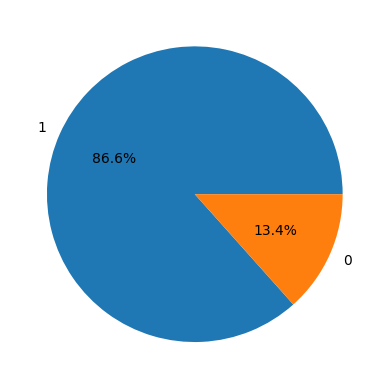

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.pie(
    grid_data["count"].where(grid_data["count"] == 1, 0).value_counts(),
    labels=[1, 0],
    autopct="%1.1f%%",
)

And finally let's fill a raster with the gridded data and save it to file.

Note that in `grid_df_to_raster` we first generate a reference raster at the desired resolution and then match the `xarray.Dataset` we created from our gridded DataFrame to the reference raster. This is important, because, due to minor differences in floating point accuracy, the rasterized DataFrame's coordinates may be subtly different than those of our EO predictor data. If we first match all training data to a reference raster, however, we can ensure that all coordinates will match perfectly.

In [1]:
from src.utils.df_utils import grid_df_to_raster


rast = grid_df_to_raster(
    grid_data, 1000, crs="EPSG:6933", name=cols[0], pack=False
)

NameError: name 'grid_data' is not defined

And lastly, let's shut down our Dask cluster.

In [41]:
client.close()
cluster.close()